## Część 1. California Home Index - prognoza Timesfm

In [ ]:
!pip install huggingface_hub(cli)
!pip install utilsforecast
!pip install praxis
!pip install paxml
!pip install jax[cuda12]==0.4.26
!pip install einshape

/bin/bash: -c: line 1: syntax error near unexpected token `('
/bin/bash: -c: line 1: `pip install huggingface_hub(cli)'
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 732.6 kB/s eta 0:00:00
INFO: pip is looking at multiple versions of praxis to determine which version is compatible with other requirements. This could take a while.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 24.6 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 56.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
INFO: pip is still looking at multiple versions of praxis to determine which version is compatible with other requirements. This could take a while.
ERROR: Cannot install praxis==0.1, praxis==0.2.0, praxis==0.2.1, praxis==0.3.0, praxis==0.4.0, praxis==1.0.0, praxis==1.1.0, praxis==1.2.0, praxis==1.3.0, praxis==1.3.1 and p

In [ ]:
!pip install timesfm[pax]

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.7/67.7 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.7/54.7 kB 4.5 MB/s eta 0:00:00


In [ ]:
import timesfm
import pandas as pd
from matplotlib import pyplot as plt
import yfinance as yf
from sklearn.metrics import mean_absolute_percentage_error

 See https://github.com/google-research/timesfm/blob/master/README.md for updated APIs.
Loaded PyTorch TimesFM, likely because python version is 3.11.12 (main, Apr  9 2025, 08:55:54) [GCC 11.4.0].


In [ ]:
tfm = timesfm.TimesFm(
      hparams=timesfm.TimesFmHparams(
          backend="gpu",
          per_core_batch_size=4,
          horizon_len=4,
          num_layers=50,
          use_positional_embedding=False,
          context_len=96,
      ),
      checkpoint=timesfm.TimesFmCheckpoint(
          huggingface_repo_id="google/timesfm-2.0-500m-pytorch"),
  )

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Fetching 5 files:   0%|          | 0/5 [00:00<?, ?it/s]

README.md:   0%|          | 0.00/7.35k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/692 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.00G [00:00<?, ?B/s]

torch_model.ckpt:   0%|          | 0.00/2.00G [00:00<?, ?B/s]

.gitattributes:   0%|          | 0.00/1.57k [00:00<?, ?B/s]

In [ ]:
df = pd.read_csv("CASTHPI.csv")
df.rename(columns={'observation_date': 'ds', 'CASTHPI': 'value'}, inplace=True)
df['ds'] = pd.to_datetime(df['ds'])
df['unique_id']="California_index"
print(df.head(10))
df.shape
df.tail(10)

          ds  value         unique_id
0 1975-01-01  41.69  California_index
1 1975-04-01  42.77  California_index
2 1975-07-01  44.35  California_index
3 1975-10-01  45.78  California_index
4 1976-01-01  47.82  California_index
5 1976-04-01  50.28  California_index
6 1976-07-01  53.58  California_index
7 1976-10-01  55.60  California_index
8 1977-01-01  58.03  California_index
9 1977-04-01  63.02  California_index


,ds,value,unique_id
190,2022-07-01,915.45,California_index
191,2022-10-01,891.69,California_index
192,2023-01-01,888.87,California_index
193,2023-04-01,911.51,California_index
194,2023-07-01,923.45,California_index
195,2023-10-01,926.65,California_index
196,2024-01-01,941.18,California_index
197,2024-04-01,956.39,California_index
198,2024-07-01,965.29,California_index
199,2024-10-01,968.88,California_index


test size: 20
            ds   value         unique_id
180 2020-01-01  669.69  California_index
181 2020-04-01  677.37  California_index
182 2020-07-01  685.31  California_index
183 2020-10-01  699.46  California_index
184 2021-01-01  719.04  California_index
            ds   value         unique_id
195 2023-10-01  926.65  California_index
196 2024-01-01  941.18  California_index
197 2024-04-01  956.39  California_index
198 2024-07-01  965.29  California_index
199 2024-10-01  968.88  California_index


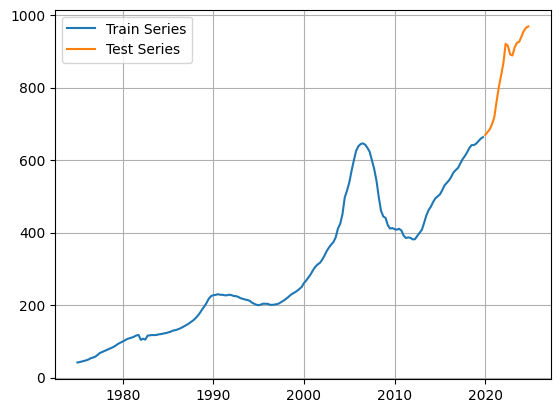

In [ ]:
test_size = int(0.1 * len(df))
train_df = df.head(len(df) - test_size)
test_df = df.tail(test_size)
print("test size:", test_size)
plt.plot(train_df['ds'], train_df['value'], label = "Train Series")
plt.plot(test_df['ds'], test_df['value'], label = "Test Series")
plt.legend()
plt.grid()
print(test_df.head(5))
print(test_df.tail(5))

In [ ]:
forecast_df = tfm.forecast_on_df(
    inputs=train_df,
    freq="Q",  # quarterly
    value_name="value",
    num_jobs=-1,
)

Processing dataframe with multiple processes.


/usr/lib/python3.11/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Finished preprocessing dataframe.
Finished forecasting.


/usr/local/lib/python3.11/dist-packages/utilsforecast/processing.py:384: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  freq = pd.tseries.frequencies.to_offset(freq)
/usr/local/lib/python3.11/dist-packages/utilsforecast/processing.py:440: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  freq = pd.tseries.frequencies.to_offset(freq)


In [ ]:
forecast_df

,unique_id,ds,timesfm,timesfm-q-0.1,timesfm-q-0.2,timesfm-q-0.3,timesfm-q-0.4,timesfm-q-0.5,timesfm-q-0.6,timesfm-q-0.7,timesfm-q-0.8,timesfm-q-0.9
0,California_index,2019-12-31,654.793823,646.366943,650.146362,652.190430,653.404053,654.793823,655.748535,658.021362,660.140686,663.969849
1,California_index,2020-03-31,664.657837,656.235901,659.181030,662.389282,662.690002,664.657837,666.640625,668.280762,671.894409,674.823608
2,California_index,2020-06-30,668.809204,656.179443,662.472656,664.360718,666.331787,668.809204,670.402588,673.124756,675.375610,679.305908
3,California_index,2020-09-30,682.125244,669.016968,674.647034,677.234375,680.304077,682.125244,685.147461,687.797607,690.002686,694.802124
4,California_index,2020-12-31,680.909912,665.129395,671.872070,675.437744,678.820435,680.909912,684.165222,687.464478,691.303772,696.433716
5,California_index,2021-03-31,688.037109,670.278687,677.891418,682.127625,684.974731,688.037109,691.565430,695.502502,699.539246,704.847046
6,California_index,2021-06-30,695.199585,674.808289,684.224976,688.051392,691.802246,695.199585,698.512207,702.813782,707.110107,713.404785
7,California_index,2021-09-30,701.239136,682.021057,689.979980,694.467407,697.773193,701.239136,704.440063,707.647095,712.249817,718.526001


In [ ]:
error = mean_absolute_percentage_error(test_df['value'][:8], forecast_df['timesfm'])
print(f"MAPE: {error:.4f}")

MAPE: 0.0664


## Walk-forward validation z 2-letnim oknem


Trening: do 2020-01-01, Test: od 2020-01-02 do 2021-01-01
Processing dataframe with multiple processes.


/usr/lib/python3.11/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Finished preprocessing dataframe.
Finished forecasting.
MAPE dla okna: 0.03%


/usr/local/lib/python3.11/dist-packages/utilsforecast/processing.py:384: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  freq = pd.tseries.frequencies.to_offset(freq)
/usr/local/lib/python3.11/dist-packages/utilsforecast/processing.py:440: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  freq = pd.tseries.frequencies.to_offset(freq)


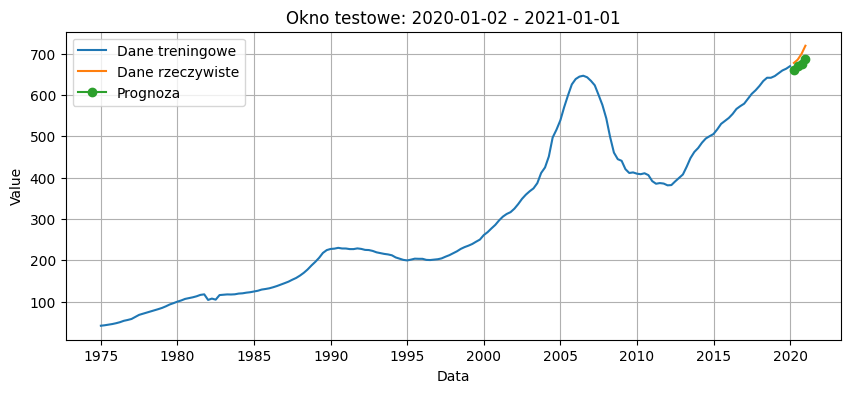


Trening: do 2021-01-01, Test: od 2021-01-02 do 2022-01-01
Processing dataframe with multiple processes.


/usr/lib/python3.11/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Finished preprocessing dataframe.
Finished forecasting.
MAPE dla okna: 0.11%


/usr/local/lib/python3.11/dist-packages/utilsforecast/processing.py:384: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  freq = pd.tseries.frequencies.to_offset(freq)
/usr/local/lib/python3.11/dist-packages/utilsforecast/processing.py:440: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  freq = pd.tseries.frequencies.to_offset(freq)


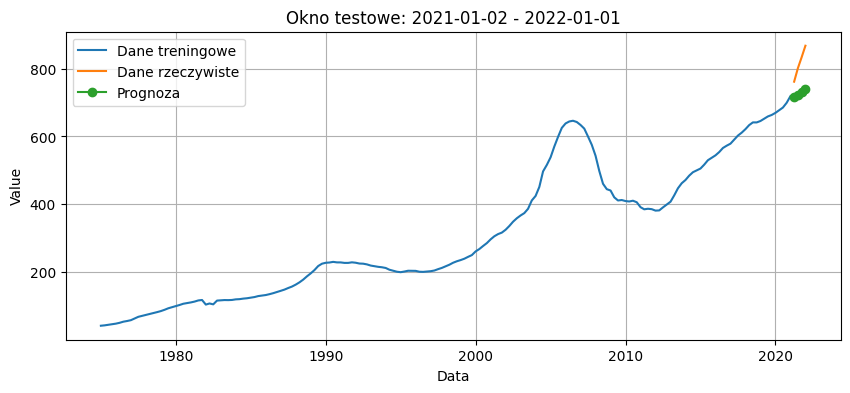


Trening: do 2022-01-01, Test: od 2022-01-02 do 2023-01-01
Processing dataframe with multiple processes.


/usr/lib/python3.11/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.11/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Finished preprocessing dataframe.
Finished forecasting.
MAPE dla okna: 0.05%


/usr/local/lib/python3.11/dist-packages/utilsforecast/processing.py:384: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  freq = pd.tseries.frequencies.to_offset(freq)
/usr/local/lib/python3.11/dist-packages/utilsforecast/processing.py:440: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  freq = pd.tseries.frequencies.to_offset(freq)


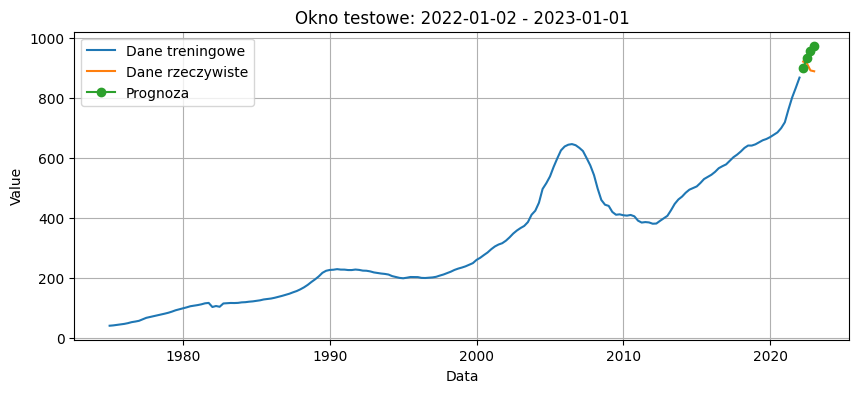


Trening: do 2023-01-01, Test: od 2023-01-02 do 2024-01-01
Processing dataframe with multiple processes.


/usr/lib/python3.11/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.11/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Finished preprocessing dataframe.
Finished forecasting.
MAPE dla okna: 0.01%


/usr/local/lib/python3.11/dist-packages/utilsforecast/processing.py:384: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  freq = pd.tseries.frequencies.to_offset(freq)
/usr/local/lib/python3.11/dist-packages/utilsforecast/processing.py:440: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  freq = pd.tseries.frequencies.to_offset(freq)


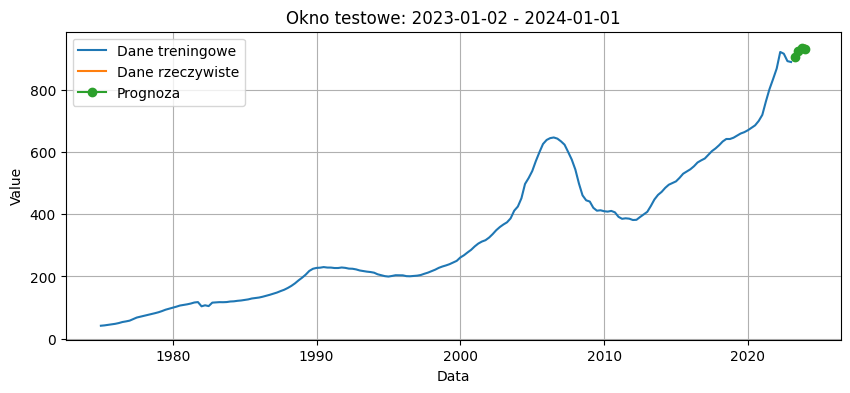


Średnie MAPE dla wszystkich okien: 0.05%


In [ ]:
import numpy as np
# Funkcja do obliczania MAPE
# def mape(y_true, y_pred):
#     y_true, y_pred = np.array(y_true), np.array(y_pred)
#     return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Zakładamy, że df ma kolumny: 'ds' (datetime) oraz 'value'
#df = df.sort_values('ds')

# Ustalmy początkowy zbiór treningowy jako pierwsza połowa danych
split_index = int(len(df) * 0.9)
initial_train_end = df['ds'].iloc[split_index]

# Ustawiamy horyzont prognozy na 2 lata (przy danych kwartalnych to 8 kwartałów)
forecast_horizon = pd.DateOffset(years=1)

# Inicjujemy training set jako dane do początkowego momentu
train_df = df[df['ds'] <= initial_train_end].copy()
current_train_end = initial_train_end

mape_scores = []

# Pętla walk-forward - tak długo, jak testowy okres mieści się w danych
while current_train_end + forecast_horizon <= df['ds'].max():
    # Określamy okres testowy: od dnia po zakończeniu treningu do 2 lat do przodu
    test_start = current_train_end + pd.DateOffset(days=1)
    test_end = current_train_end + forecast_horizon

    test_df = df[(df['ds'] >= test_start) & (df['ds'] <= test_end)].copy()
    if test_df.empty:
        print("Brak danych testowych w tym oknie.")
        break

    print(f"\nTrening: do {current_train_end.date()}, Test: od {test_start.date()} do {test_end.date()}")

    # Prognoza na podstawie bieżącego zbioru treningowego
    forecast_df = tfm.forecast_on_df(
        inputs=train_df,
        freq="Q",         # dane kwartalne
        value_name="value",
        num_jobs=-1,
    )

    # Zakładamy, że forecast_df zawiera kolumny: 'ds' (daty) oraz 'yhat' (prognozowane wartości)
    forecast_test = forecast_df[(forecast_df['ds'] >= test_start) & (forecast_df['ds'] <= test_end)].copy()
    if forecast_test.empty:
        print("Brak prognozy dla okresu testowego.")
        break

    # Aby dopasować daty, wykorzystamy merge_asof (łączenie najbliższych dat z tolerancją)
    merged = pd.merge_asof(
        test_df.sort_values('ds'),
        forecast_test.sort_values('ds'),
        on='ds',
        direction='nearest',
        tolerance=pd.Timedelta('31D')  # dopasowanie w obrębie 31 dni (dostosuj w razie potrzeby)
    )

    if merged.empty:
        print("Brak dopasowanych dat między forecast a danymi testowymi.")
    else:
        current_mape = mean_absolute_percentage_error(merged['value'], merged['timesfm'])
        mape_scores.append(current_mape)
        print(f"MAPE dla okna: {current_mape:.2f}%")

        # (Opcjonalnie) Rysujemy wykres dla danego okna
        plt.figure(figsize=(10,4))
        plt.plot(train_df['ds'], train_df['value'], label="Dane treningowe")
        plt.plot(merged['ds'], merged['value'], label="Dane rzeczywiste")
        plt.plot(merged['ds'], merged['timesfm'], label="Prognoza", marker='o')
        plt.xlabel("Data")
        plt.ylabel("Value")
        plt.title(f"Okno testowe: {test_start.date()} - {test_end.date()}")
        plt.legend()
        plt.grid()
        plt.show()

    # Rozszerzamy okno treningowe o okres testowy (expanding window) i przesuwamy horyzont
    train_df = df[df['ds'] <= test_end].copy()
    current_train_end = test_end

# Wyliczenie średniego MAPE
if mape_scores:
    avg_mape = np.mean(mape_scores)
    print(f"\nŚrednie MAPE dla wszystkich okien: {avg_mape:.2f}%")
else:
    print("Brak obliczonych wyników MAPE.")



OKNO TESTOWE: 2020-01-01 – 2020-10-01 (pkt: [Timestamp('2020-01-01 00:00:00'), Timestamp('2020-04-01 00:00:00'), Timestamp('2020-07-01 00:00:00'), Timestamp('2020-10-01 00:00:00')])
Processing dataframe with multiple processes.


/usr/lib/python3.11/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Finished preprocessing dataframe.
Finished forecasting.
  → MAPE: 1.64%

OKNO TESTOWE: 2021-01-01 – 2021-10-01 (pkt: [Timestamp('2021-01-01 00:00:00'), Timestamp('2021-04-01 00:00:00'), Timestamp('2021-07-01 00:00:00'), Timestamp('2021-10-01 00:00:00')])
Processing dataframe with multiple processes.


/usr/lib/python3.11/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Finished preprocessing dataframe.
Finished forecasting.
  → MAPE: 6.46%

OKNO TESTOWE: 2022-01-01 – 2022-10-01 (pkt: [Timestamp('2022-01-01 00:00:00'), Timestamp('2022-04-01 00:00:00'), Timestamp('2022-07-01 00:00:00'), Timestamp('2022-10-01 00:00:00')])
Processing dataframe with multiple processes.


/usr/lib/python3.11/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.11/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Finished preprocessing dataframe.
Finished forecasting.
  → MAPE: 2.09%

OKNO TESTOWE: 2023-01-01 – 2023-10-01 (pkt: [Timestamp('2023-01-01 00:00:00'), Timestamp('2023-04-01 00:00:00'), Timestamp('2023-07-01 00:00:00'), Timestamp('2023-10-01 00:00:00')])
Processing dataframe with multiple processes.


/usr/lib/python3.11/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Finished preprocessing dataframe.
Finished forecasting.
  → MAPE: 5.16%

OKNO TESTOWE: 2024-01-01 – 2024-10-01 (pkt: [Timestamp('2024-01-01 00:00:00'), Timestamp('2024-04-01 00:00:00'), Timestamp('2024-07-01 00:00:00'), Timestamp('2024-10-01 00:00:00')])
Processing dataframe with multiple processes.


/usr/lib/python3.11/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Finished preprocessing dataframe.
Finished forecasting.
  → MAPE: 2.15%


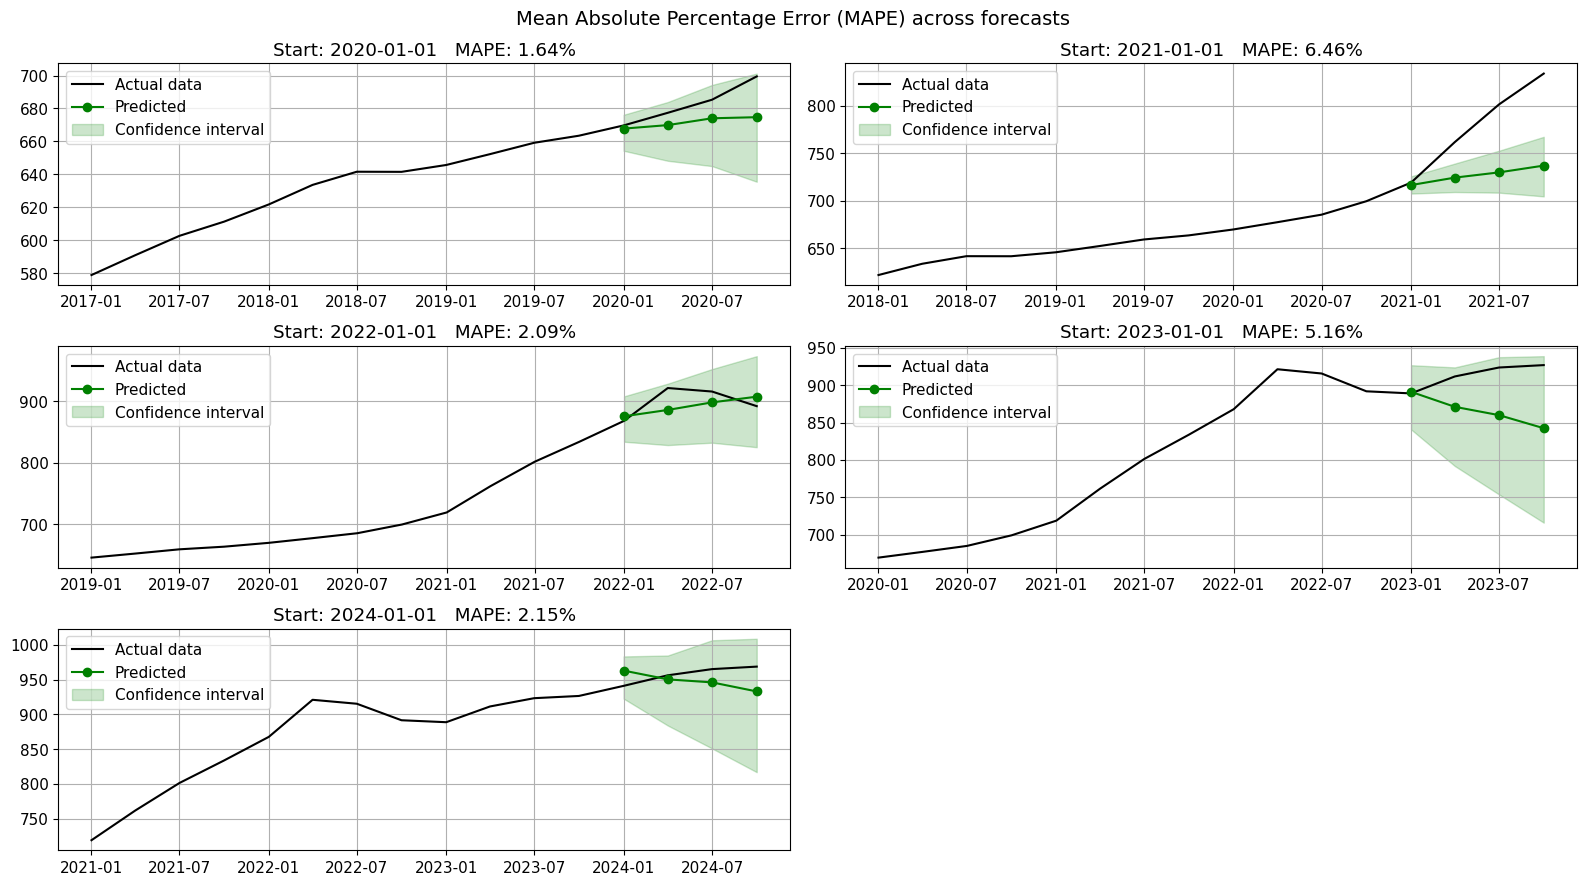


Średnie MAPE dla wszystkich okien: 3.50%


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_percentage_error
import math

# ------------------------------------------------------------------
# Założenia (jak poprzednio):
# - df z kolumnami 'ds' (datetime kvartalnie: 2020-01-01,04-01,07-01,10-01…), 'value'
# - forecast_df = tfm.forecast_on_df(...) zwraca DataFrame z kolumnami:
#     'ds', 'timesfm-q-0.1', 'timesfm-q-0.5', 'timesfm-q-0.9'
# - Chcemy: okna testowe = cztery punkty kwartalne [YYYY-01-01, YYYY-04-01, YYYY-07-01, YYYY-10-01]
# - Jeżeli forecast_df nie ma dokł. tych dat, użyjemy merge_asof, by dopasować najbliższą kwartalną prognozę.
# ------------------------------------------------------------------

df = df.sort_values('ds').reset_index(drop=True)
df['ds'] = pd.to_datetime(df['ds'])
full_ts = df.set_index('ds')['value']

# 1) Ustawienie splitu 90% → initial_train_end
split_index = int(round(len(df) * 0.9)) - 1
if split_index < 0:
    split_index = 0
initial_train_end = df.loc[split_index, 'ds']
train_df = df[df['ds'] <= initial_train_end].copy()

# 2) Lista lat do okien testowych (każde zaczyna się 1 stycznia)
first_test_year = initial_train_end.year + 1
last_data_year  = df['ds'].dt.year.max()
years = list(range(first_test_year, last_data_year + 1))

# 3) Przygotowanie struktur na wyniki
forecast_starts = []
mape_scores    = []
forecast_dfs   = []   # nie będziemy tu trzymać już tylko "kwartalnych" dat, lecz cały fragment prognozy
test_data_ts   = []

# 4) Offsets kwartalne (0,3,6,9 miesięcy)
offsets = [
    pd.DateOffset(months=0),   # 1.01.YYYY
    pd.DateOffset(months=3),   # 1.04.YYYY
    pd.DateOffset(months=6),   # 1.07.YYYY
    pd.DateOffset(months=9)    # 1.10.YYYY
]

for Y in years:
    # a) Początek okna testowego = YYYY-01-01
    test_start = pd.Timestamp(year=Y, month=1, day=1)
    if test_start <= initial_train_end:
        continue

    # b) Tworzymy cztery dokładne daty kwartalne
    quarterly_dates = [test_start + off for off in offsets]

    # c) Przycinamy do max(df['ds']), jeśli któryś z tych offsetów wypada poza dane
    max_date = df['ds'].max()
    quarterly_dates = [d for d in quarterly_dates if d <= max_date]
    if not quarterly_dates:
        continue

    # d) Rzeczywiste dane testowe: wiersze df dla punktów quarterly_dates
    test_df = df[df['ds'].isin(quarterly_dates)].copy()
    if test_df.empty:
        continue

    # e) Definiujemy test_end jako ostatnią kwartalną datę (np. 1.10.YYYY)
    test_end = max(quarterly_dates)
    print(f"\nOKNO TESTOWE: {test_start.date()} – {test_end.date()} (pkt: {quarterly_dates})")

    # f) Generujemy prognozę na cały zakres historyczny → forecast_df
    forecast_df = tfm.forecast_on_df(
        inputs=train_df,
        freq="QS",
        value_name="value",
        num_jobs=-1,
    ).copy()

    # g) WYTNIĘCIE całego fragmentu prognozy z okresu [test_start, test_end]
    fc_window = forecast_df[
        (forecast_df['ds'] >= test_start) &
        (forecast_df['ds'] <= test_end)
    ].copy()
    if fc_window.empty:
        print("  → Brak prognozy w zadanym oknie. Pomijam.")
        continue

    # h) MERGE_ASOF: dopasowujemy do dokładnych kwartałów z test_df
    merged = pd.merge_asof(
        test_df.sort_values('ds'),
        fc_window.sort_values('ds'),
        on='ds',
        direction='nearest',
        tolerance=pd.Timedelta('31D')
    )
    # usuwamy wiersze, w których dalej są NaN-y (np. nie było prognozy w tolerancji)
    merged = merged.dropna(subset=['value', 'timesfm-q-0.5'])
    if merged.empty:
        print("  → Po dropna() nie ma punktów do porównania. Pomijam.")
        continue

    # i) LICZYMY MAPE względem mediany prognozy
    current_mape = mean_absolute_percentage_error(
        merged['value'],
        merged['timesfm-q-0.5']
    )
    mape_scores.append(current_mape)

    # j) ZAPAMIĘTANIE:
    forecast_starts.append(test_start)
    #   * cały wycinek prognozy (tes_start..test_end) – tylko po to, by później mieć indeks i kolumny
    #     fc_window ma kolumny: 'ds', 'timesfm-q-0.1', 'timesfm-q-0.5', 'timesfm-q-0.9'
    fc_window = fc_window.set_index('ds')[['timesfm-q-0.1', 'timesfm-q-0.5', 'timesfm-q-0.9']]
    forecast_dfs.append(fc_window)

    #   * seria rzeczywistych wartości testowych (dokładnie quarterly_dates)
    test_series = test_df.set_index('ds')['value']
    test_data_ts.append(test_series)

    print(f"  → MAPE: {current_mape * 100:.2f}%")

    # k) ROZSZERZAMY zbiór treningowy do test_end
    train_df = df[df['ds'] <= test_end].copy()

# ------------------------------------------------------------
# RYSOWANIE PODWYKRESÓW (po jednym na każde okno testowe)
# ------------------------------------------------------------
if not mape_scores:
    print("Nie udało się wygenerować żadnego okna testowego.")
else:
    n_windows = len(forecast_starts)
    ncols = 2
    nrows = math.ceil(n_windows / ncols)

    plt.figure(figsize=(16, 9))
    plt.rcParams.update({'font.size': 11})

    for idx in range(n_windows):
        ax = plt.subplot(nrows, ncols, idx + 1)
        start    = forecast_starts[idx]    # Timestamp('YYYY-01-01')
        mape_val = mape_scores[idx]
        fc       = forecast_dfs[idx]       # DataFrame, idx=ds, kolumny quantile
        ts_test  = test_data_ts[idx]       # Series z rzeczywistymi wartościami (dokładnie quarterly_dates)

        # 1) Wycinamy 3 lata historii przed startem
        history_start = start - pd.DateOffset(years=3)
        t = full_ts[history_start : start]

        # 2) Wartości mediany i pasma ufności
        median_fc = fc['timesfm-q-0.5']
        lower_fc  = fc['timesfm-q-0.1']
        upper_fc  = fc['timesfm-q-0.9']

        # 3) Łączymy linię historii i testu (żeby nie było graficznej luki)
        combined_real = pd.concat([t, ts_test])

        smape = round(mape_val * 100, 2)
        ax.set_title(f"Start: {start.date()}   MAPE: {smape}%")

        # 4) Czarna ciągła: historia + test
        ax.plot(combined_real.index, combined_real.values, 'k-', label="Actual data")

        # 5) Zielone kropki/linia: mediana prognozy, ale tylko w punktach quarterly_dates
        ax.plot(median_fc.index, median_fc.values, 'g-', marker='o', label="Predicted")

        # 6) Pasmo niepewności 10–90%
        ax.fill_between(
            lower_fc.index,
            lower_fc.values,
            upper_fc.values,
            color='green',
            alpha=0.2,
            label="Confidence interval"
        )

        ax.legend()
        ax.grid(True)

    plt.gcf().tight_layout()
    plt.subplots_adjust(top=0.92)
    plt.suptitle("Mean Absolute Percentage Error (MAPE) across forecasts", fontsize=14)
    plt.show()

    avg_mape = np.mean(mape_scores)
    print(f"\nŚrednie MAPE dla wszystkich okien: {avg_mape * 100:.2f}%")


In [ ]:
tfm = timesfm.TimesFm(
      hparams=timesfm.TimesFmHparams(
          backend="gpu",
          per_core_batch_size=4,
          horizon_len=10,
          num_layers=50,
          use_positional_embedding=False,
          context_len=96,
      ),
      checkpoint=timesfm.TimesFmCheckpoint(
          huggingface_repo_id="google/timesfm-2.0-500m-pytorch"),
  )

Fetching 5 files:   0%|          | 0/5 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
test_size = int(0.1 * len(df))
train_df = df.head(len(df) - test_size)
test_df = df.tail(test_size)
print("test size:", test_size)

test size: 20


In [ ]:
forecast_df = tfm.forecast_on_df(
    inputs=train_df,
    freq="QS",  # quarterly
    value_name="value",
    num_jobs=-1,
)

Processing dataframe with multiple processes.


/usr/lib/python3.11/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Finished preprocessing dataframe.
Finished forecasting.


0.20598033347428363
MAPE: 0.2060


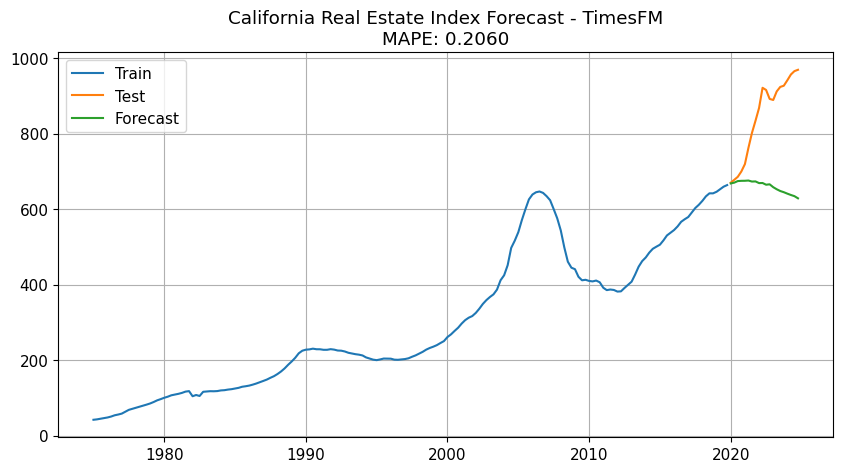

In [ ]:
# calculate error
error = mean_absolute_percentage_error(test_df['value'], forecast_df['timesfm'])
print(error)
print(f"MAPE: {error:.4f}")

# plot
plt.figure(figsize=(10,5))
plt.plot(train_df['ds'], train_df['value'], label="Train")
plt.plot(test_df['ds'], test_df['value'], label="Test")
plt.plot(forecast_df['ds'], forecast_df['timesfm'], label="Forecast")
plt.title(f"California Real Estate Index Forecast - TimesFM\nMAPE: {error:.4f}")
plt.legend()
plt.grid()
plt.show()

## Czesc 2. Prognoza REIT

In [ ]:


ticker = yf.Ticker("^REI")  # podaj symbol indeksu lub ETF-u REIT
data = ticker.history(period="30d", interval="5m")  # np. dane minutowe z jednego dnia
print(data.head())
print(data.shape)
print(data.tail())


                                 Open        High         Low       Close  \
Datetime                                                                    
2025-02-24 09:30:00-05:00  408.600006  408.929993  408.140015  408.140015   
2025-02-24 09:35:00-05:00  408.109985  408.140015  406.950012  407.380005   
2025-02-24 09:40:00-05:00  407.290009  407.440002  407.089996  407.209991   
2025-02-24 09:45:00-05:00  407.369995  407.470001  407.029999  407.299988   
2025-02-24 09:50:00-05:00  407.290009  408.579987  407.200012  408.549988   
2025-02-24 09:55:00-05:00  408.549988  409.010010  408.320007  408.940002   
2025-02-24 10:00:00-05:00  408.970001  408.970001  408.279999  408.739990   
2025-02-24 10:05:00-05:00  408.739990  411.049988  408.500000  410.950012   
2025-02-24 10:10:00-05:00  410.950012  410.950012  409.579987  409.690002   
2025-02-24 10:15:00-05:00  409.670013  409.980011  409.500000  409.649994   
2025-02-24 10:20:00-05:00  409.660004  410.540009  409.489990  410.440002   

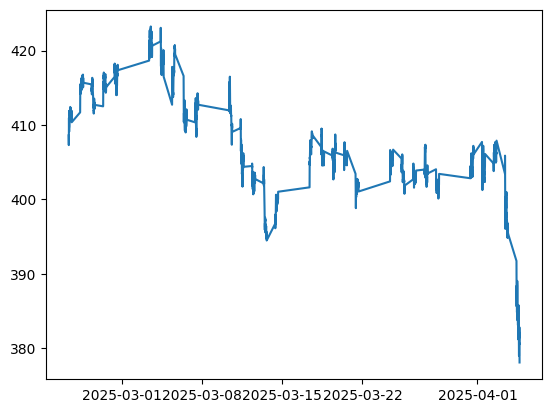

In [ ]:
df_reit = data.reset_index()
df_reit.rename(columns={'Datetime': 'ds'}, inplace=True)
#df_reit['ds']=pd.to_datetime(df_reit['ds'])
# Zakładamy, że kolumna nazywa się 'ds'
#df_reit['ds'] = df_reit['ds'].dt.tz_localize(None)

df_reit=df_reit.iloc[:,0:5]
df_reit['unique_id']='REIT'

plt.plot(df_reit['ds'], df_reit['Open'])

In [ ]:
tfm_reit = timesfm.TimesFm(
      hparams=timesfm.TimesFmHparams(
          backend="gpu",
          per_core_batch_size=32,
          horizon_len=32,
          num_layers=50,
          use_positional_embedding=False,
          context_len=2304,
      ),
      checkpoint=timesfm.TimesFmCheckpoint(
          huggingface_repo_id="google/timesfm-2.0-500m-pytorch"),
  )

Fetching 5 files:   0%|          | 0/5 [00:00<?, ?it/s]

test size: 32


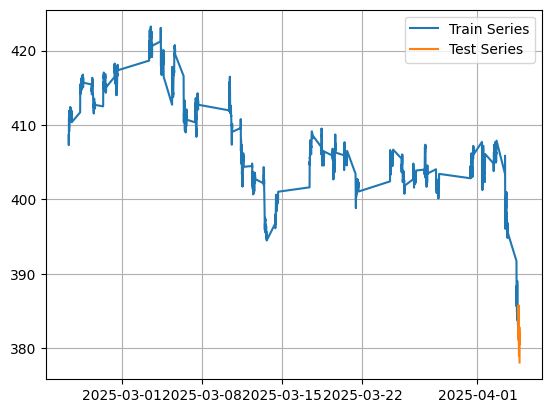

In [ ]:
test_size = int(0.014 * len(df_reit))
train_df = df_reit.head(len(df_reit) - test_size)
test_df = df_reit.tail(test_size)
print("test size:", test_size)
plt.plot(train_df['ds'], train_df['Open'], label = "Train Series")
plt.plot(test_df['ds'], test_df['Open'], label = "Test Series")
plt.legend()
plt.grid()

In [ ]:
forecast_df_reit = tfm_reit.forecast_on_df(
    inputs=train_df,
    freq="5T",  # 5 minutes
    value_name="Open",
    num_jobs=-1,
)

Processing dataframe with multiple processes.


/usr/lib/python3.11/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.11/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Finished preprocessing dataframe.
Finished forecasting.


/usr/local/lib/python3.11/dist-packages/utilsforecast/processing.py:384: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  freq = pd.tseries.frequencies.to_offset(freq)
/usr/local/lib/python3.11/dist-packages/utilsforecast/processing.py:440: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  freq = pd.tseries.frequencies.to_offset(freq)


In [ ]:
forecast_df_reit

,unique_id,ds,timesfm,timesfm-q-0.1,timesfm-q-0.2,timesfm-q-0.3,timesfm-q-0.4,timesfm-q-0.5,timesfm-q-0.6,timesfm-q-0.7,timesfm-q-0.8,timesfm-q-0.9
0,REIT,2025-04-04 13:20:00-04:00,380.301361,379.233582,379.710114,379.978149,380.152344,380.301361,380.545685,380.851746,381.226593,381.795959
1,REIT,2025-04-04 13:25:00-04:00,380.429993,378.979462,379.616974,379.946289,380.217072,380.429993,380.692719,381.137329,381.617096,382.482697
2,REIT,2025-04-04 13:30:00-04:00,380.430969,378.611572,379.379028,379.837433,380.157043,380.430969,380.800964,381.320404,381.985626,383.063202
3,REIT,2025-04-04 13:35:00-04:00,380.711792,378.477356,379.409668,379.954498,380.323608,380.711792,381.117218,381.726166,382.505798,383.782288
4,REIT,2025-04-04 13:40:00-04:00,380.766510,378.271912,379.300751,379.899567,380.320160,380.766510,381.258850,381.949799,382.833679,384.294098
5,REIT,2025-04-04 13:45:00-04:00,380.830627,378.110382,379.182251,379.837494,380.349091,380.830627,381.395447,382.158569,383.175568,384.820343
6,REIT,2025-04-04 13:50:00-04:00,380.768860,377.814972,378.942993,379.684296,380.245117,380.768860,381.397888,382.264771,383.363312,385.148224
7,REIT,2025-04-04 13:55:00-04:00,380.887573,377.719269,378.894775,379.683167,380.296936,380.887573,381.577667,382.536804,383.754120,385.684265
8,REIT,2025-04-04 14:00:00-04:00,381.044220,377.579834,378.924744,379.728058,380.395996,381.044220,381.821014,382.813751,384.112427,386.192444
9,REIT,2025-04-04 14:05:00-04:00,381.064667,377.430176,378.792511,379.674927,380.393982,381.064667,381.872864,382.940033,384.348755,386.581207


## Prognoza dla w ramach jednego dnia (ale na podstawie prawie miesiąca)

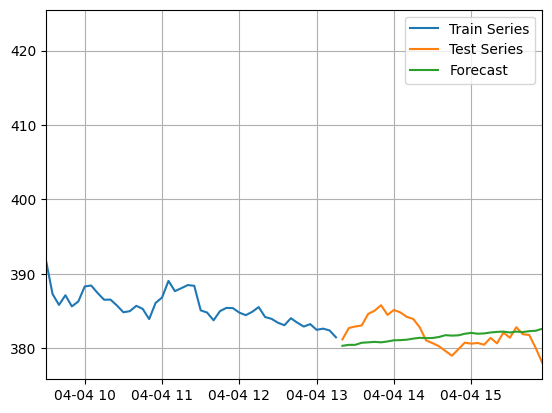

In [ ]:
plt.plot(train_df['ds'], train_df['Open'], label = "Train Series")
plt.plot(test_df['ds'], test_df['Open'], label = "Test Series")
plt.plot(forecast_df_reit['ds'], forecast_df_reit['timesfm'], label="Forecast")

left_limit = pd.to_datetime('2025-04-04 09:30:00-04:00')
right_limit = pd.to_datetime('2025-04-04 15:55:00-04:00 ')
plt.xlim(left=left_limit, right=right_limit)
plt.legend()
plt.grid()

## 3. Prognoza TimesFm dla EQR

In [ ]:
eqr = yf.Ticker("EQR")
df = eqr.history(period="max")
df.info()

df_eqr = df.reset_index()
df_eqr

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 7968 entries, 1993-08-12 00:00:00-04:00 to 2025-04-07 00:00:00-04:00
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Open          7968 non-null   float64
 1   High          7968 non-null   float64
 2   Low           7968 non-null   float64
 3   Close         7968 non-null   float64
 4   Volume        7968 non-null   int64  
 5   Dividends     7968 non-null   float64
 6   Stock Splits  7968 non-null   float64
dtypes: float64(6), int64(1)
memory usage: 498.0 KB


,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits
0,1993-08-12 00:00:00-04:00,2.790389,2.790389,2.634031,2.754307,13086600,0.0,0.0
1,1993-08-13 00:00:00-04:00,2.742279,2.742279,2.670114,2.670114,1277800,0.0,0.0
2,1993-08-16 00:00:00-04:00,2.670113,2.694168,2.658085,2.694168,559000,0.0,0.0
3,1993-08-17 00:00:00-04:00,2.694169,2.718224,2.682141,2.706196,545600,0.0,0.0
4,1993-08-18 00:00:00-04:00,2.706196,2.706196,2.706196,2.706196,469200,0.0,0.0
...,...,...,...,...,...,...,...,...
7963,2025-04-01 00:00:00-04:00,71.580002,71.959999,70.449997,71.279999,1379200,0.0,0.0
7964,2025-04-02 00:00:00-04:00,70.860001,71.970001,70.599998,71.629997,1376700,0.0,0.0
7965,2025-04-03 00:00:00-04:00,70.970001,71.540001,68.239998,68.550003,1816200,0.0,0.0
7966,2025-04-04 00:00:00-04:00,67.629997,68.199997,63.630001,63.790001,2449900,0.0,0.0


<ipython-input-9-278a92947bb9>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_eqr['unique_id']='EQR'


                         ds      Open unique_id
0 1993-08-12 00:00:00-04:00  2.790389       EQR
1 1993-08-13 00:00:00-04:00  2.742279       EQR
2 1993-08-16 00:00:00-04:00  2.670113       EQR
3 1993-08-17 00:00:00-04:00  2.694169       EQR
4 1993-08-18 00:00:00-04:00  2.706196       EQR


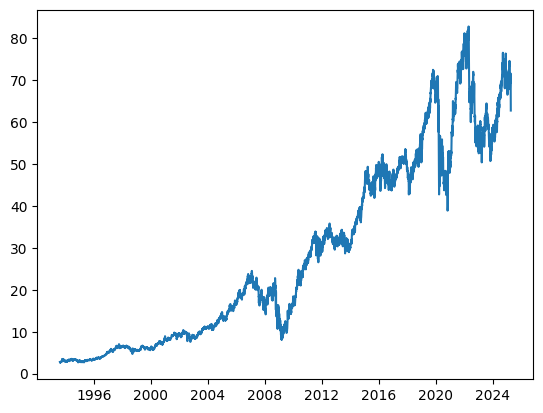

In [ ]:
df_eqr.rename(columns={'Date': 'ds'}, inplace=True)

df_eqr = df_eqr[['ds', 'Open']]

df_eqr['unique_id']='EQR'

plt.plot(df_eqr['ds'], df_eqr['Open'])
print(df_eqr.head())

In [ ]:
tfm_reit = timesfm.TimesFm(
      hparams=timesfm.TimesFmHparams(
          backend="gpu",
          per_core_batch_size=32,
          horizon_len=32,
          num_layers=50,
          #use_positional_embedding=False,
          context_len=2304,
      ),
      checkpoint=timesfm.TimesFmCheckpoint(
          huggingface_repo_id="google/timesfm-2.0-500m-pytorch"),
  )

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Fetching 5 files:   0%|          | 0/5 [00:00<?, ?it/s]

.gitattributes:   0%|          | 0.00/1.57k [00:00<?, ?B/s]

torch_model.ckpt:   0%|          | 0.00/2.00G [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.00G [00:00<?, ?B/s]

config.json:   0%|          | 0.00/663 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/7.35k [00:00<?, ?B/s]

In [ ]:
train_end = round(len(df_eqr) * 0.9)

train = df_eqr[:train_end]
test = df_eqr[train_end:]

# Upewnij się, że kolumna 'ds' jest datetime
df_eqr['ds'] = pd.to_datetime(df_eqr['ds'])

# Pobierz datę z kolumny 'ds' zamiast z indeksu:
start_date = df_eqr['ds'].iloc[train_end]
date_list = pd.date_range(start_date, periods=11, freq="30d").tolist()
print(date_list)


[Timestamp('2022-02-02 00:00:00-0500', tz='America/New_York'), Timestamp('2022-03-04 00:00:00-0500', tz='America/New_York'), Timestamp('2022-04-03 00:00:00-0400', tz='America/New_York'), Timestamp('2022-05-03 00:00:00-0400', tz='America/New_York'), Timestamp('2022-06-02 00:00:00-0400', tz='America/New_York'), Timestamp('2022-07-02 00:00:00-0400', tz='America/New_York'), Timestamp('2022-08-01 00:00:00-0400', tz='America/New_York'), Timestamp('2022-08-31 00:00:00-0400', tz='America/New_York'), Timestamp('2022-09-30 00:00:00-0400', tz='America/New_York'), Timestamp('2022-10-30 00:00:00-0400', tz='America/New_York'), Timestamp('2022-11-29 00:00:00-0500', tz='America/New_York')]


<ipython-input-26-2d6c0831bef5>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_eqr['ds'] = pd.to_datetime(df_eqr['ds'])


In [ ]:
tfm_eqr = timesfm.TimesFm(
      hparams=timesfm.TimesFmHparams(
          backend="gpu",
          per_core_batch_size=32,
          horizon_len=32,
          num_layers=50,
          use_positional_embedding=False,
          context_len=2304,
      ),
      checkpoint=timesfm.TimesFmCheckpoint(
          huggingface_repo_id="google/timesfm-2.0-500m-pytorch"),
  )

Fetching 5 files:   0%|          | 0/5 [00:00<?, ?it/s]

In [ ]:
d = pd.to_datetime('2022-02-02 00:00:00-0500')

forecast_df_eqr = tfm_eqr.forecast_on_df(
      inputs=train,
      freq="1D",  # day
      value_name="Open",
      num_jobs=-1,
  )
subtest = test[(test['ds'] >= d) & (test['ds'] < d + pd.Timedelta(days=30))][['Open','ds']]
print(subtest.info())

print(forecast_df_eqr.info())

Processing dataframe with multiple processes.


/usr/lib/python3.11/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Finished preprocessing dataframe.
Finished forecasting.
<class 'pandas.core.frame.DataFrame'>
Index: 21 entries, 7171 to 7191
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype                           
---  ------  --------------  -----                           
 0   Open    21 non-null     float64                         
 1   ds      21 non-null     datetime64[ns, America/New_York]
dtypes: datetime64[ns, America/New_York](1), float64(1)
memory usage: 504.0 bytes
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32 entries, 0 to 31
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype                           
---  ------         --------------  -----                           
 0   unique_id      32 non-null     object                          
 1   ds             32 non-null     datetime64[ns, America/New_York]
 2   timesfm        32 non-null     float32                         
 3   timesfm-q-0.1  32 non-null     float32                

   unique_id                        ds    timesfm  timesfm-q-0.1  \
0        EQR 2022-02-02 00:00:00-05:00  78.085579      76.949158   
1        EQR 2022-02-03 00:00:00-05:00  77.969612      76.587982   
2        EQR 2022-02-04 00:00:00-05:00  77.915428      76.220085   
5        EQR 2022-02-07 00:00:00-05:00  77.712349      75.276062   
6        EQR 2022-02-08 00:00:00-05:00  77.497963      74.851227   
7        EQR 2022-02-09 00:00:00-05:00  77.493248      74.667938   
8        EQR 2022-02-10 00:00:00-05:00  77.425636      74.428970   
9        EQR 2022-02-11 00:00:00-05:00  77.452087      74.161423   
12       EQR 2022-02-14 00:00:00-05:00  77.334312      73.364304   
13       EQR 2022-02-15 00:00:00-05:00  77.229126      73.081360   
14       EQR 2022-02-16 00:00:00-05:00  77.093727      72.806732   
15       EQR 2022-02-17 00:00:00-05:00  77.121727      72.614067   
16       EQR 2022-02-18 00:00:00-05:00  77.104202      72.398941   
20       EQR 2022-02-22 00:00:00-05:00  76.97193

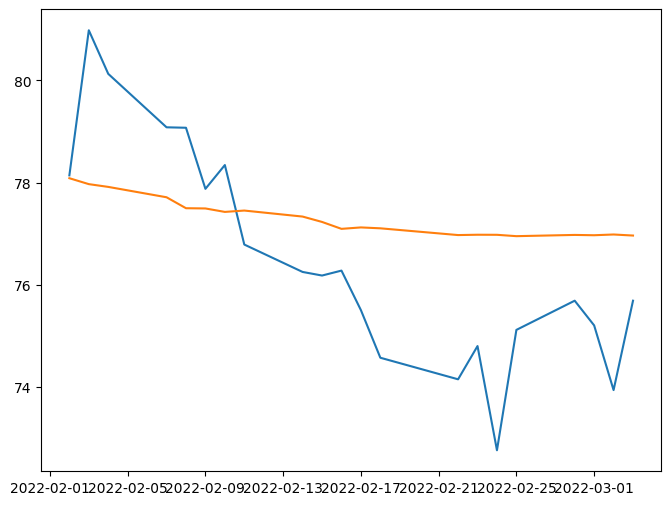

In [ ]:
# print(subtest.head(10))
# print(forecast_df_eqr.head(10))
# print(subtest.tail(10))
# print(forecast_df_eqr.tail(10))

forecast_subset = forecast_df_eqr[forecast_df_eqr['ds'].isin(subtest['ds'])]
print(forecast_subset)
mape=mean_absolute_percentage_error(subtest['Open'], forecast_subset['timesfm'])
print(mape)

plt.figure(figsize=(8,6))
plt.plot(subtest['ds'], subtest['Open'])
plt.plot(forecast_subset['ds'], forecast_subset['timesfm'])

Processing dataframe with multiple processes.


/usr/lib/python3.11/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Finished preprocessing dataframe.
Finished forecasting.
Processing dataframe with multiple processes.


/usr/lib/python3.11/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Finished preprocessing dataframe.
Finished forecasting.


ValueError: Found input variables with inconsistent numbers of samples: [21, 1]

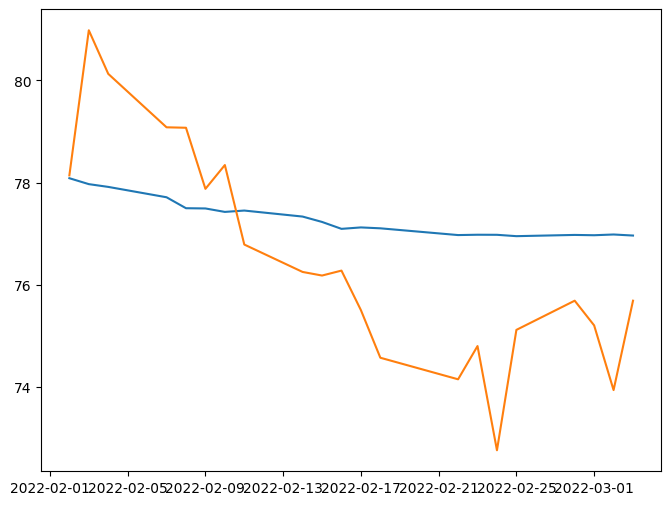

In [ ]:
df_forecasts=[]
mapes=[]

for d in range(len(date_list)):
  train_df = train[train['ds'] <= date_list[d]].copy()

  forecast_df_eqr = tfm_eqr.forecast_on_df(
      inputs=train_df,
      freq="1D",  # day
      value_name="Open",
      num_jobs=-1,
  )

  df_forecasts.append(forecast_df_eqr)
  subset = test[(test['ds'] >= date_list[d]) & (test['ds'] < date_list[d+1])][['Open','ds']]


#   merged = pd.merge_asof(
#     subtest.sort_values('ds'),
#     forecast_df_eqr.sort_values('ds'),
#     on='ds',
#     direction='nearest',
#     tolerance=pd.Timedelta('1D')  # dostosuj tolerancję według potrzeb
#   )
#  # print(merged)


# Teraz wybieramy z df_forecast wiersze, gdzie 'ds' należy do subset_dates:
  forecast_subset = forecast_df_eqr[forecast_df_eqr['ds'].isin(subset['ds'])]

  mape=mean_absolute_percentage_error(subset['Open'], forecast_subset['timesfm'])
  mapes.append(mape)


  plt.figure(figsize=(8,6))
  plt.plot(forecast_subset['ds'], forecast_subset['timesfm'], label = 'Forecats')
  plt.plot(subset['ds'], subset['Open'], label = "True values")
  #plt.plot(train_df['ds'] >= d - pd.Timedelta(days=30))

In [ ]:
print(f'Average MAPE: {sum(mapes)/len(mapes):.2f}')

Average MAPE: 0.23
